In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

%matplotlib inline 

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (15,7)

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_pickle("sanitized_df")

# extracting polarity score
df['compound'] = df.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])

# building granualrity on the time to be able to extract trend

df['year'] = df.date.dt.year
df.year = df.year.astype("category")

df['month'] = df.date.dt.month
df.month = df.month.astype("category")

df['year_month'] = df.date.dt.strftime('%y-%m')
df.year_month = df.year_month.astype('category')

df['year_month_day'] = df.date.dt.strftime('%y-%m-%d')
df.year_month_day = df.year_month_day.astype('category')



# dummies is 1-hot encoding for specific climate change topics
df_dummies = pd.read_pickle("dummies")
df = df.merge(df_dummies)



In [3]:
dummies_col = list(df.columns[14:])

# All topics analysis

<AxesSubplot:xlabel='compound', ylabel='Count'>

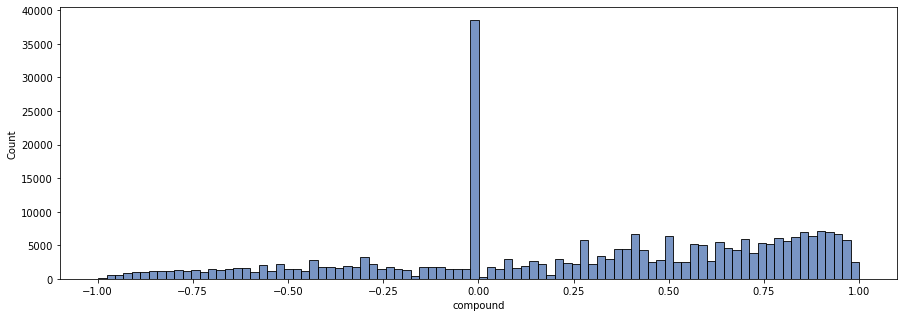

In [4]:
f,x = plt.subplots(1,1,figsize=(15,5))

sns.histplot(data=df, x='compound')

## Yearly observations

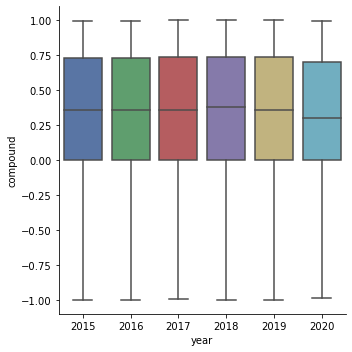

In [5]:
sns.catplot(x="year", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the years')

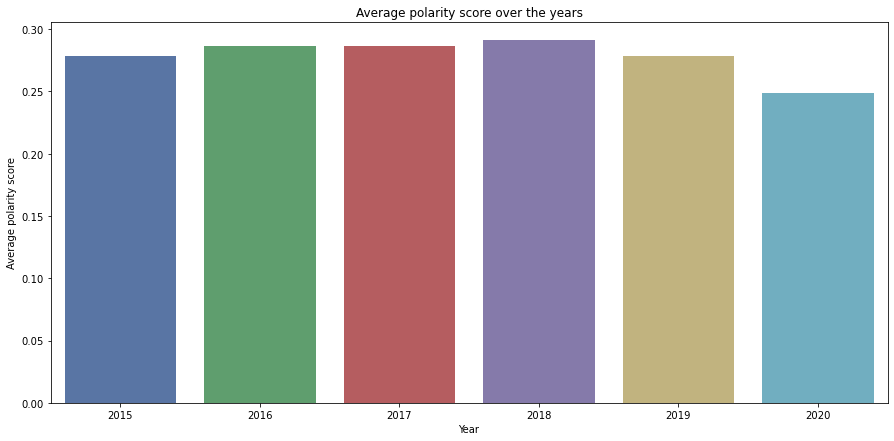

In [6]:
avg_scores = df.compound.groupby(by=df.year).mean()



g =sns.barplot(x=df.year.cat.categories, y=avg_scores)

g.set_xlabel("Year")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years")

## Monthly category

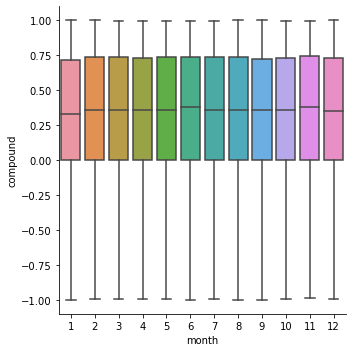

In [7]:
sns.catplot(x="month", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the months')

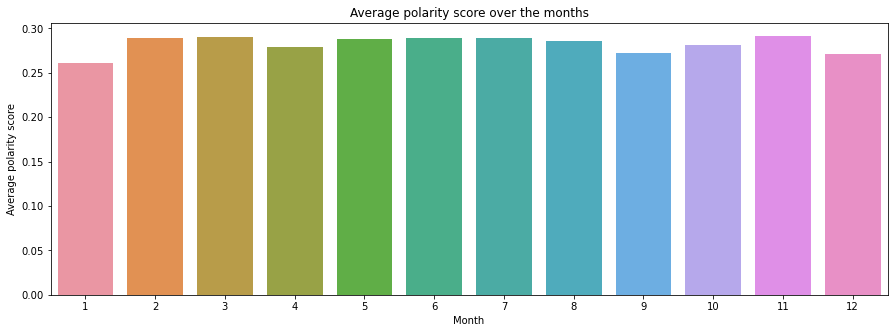

In [8]:
avg_scores = df.compound.groupby(by=df.month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.barplot(x=df.month.cat.categories, y=avg_scores)

g.set_xlabel("Month")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the months")

## Yearly-monthly category

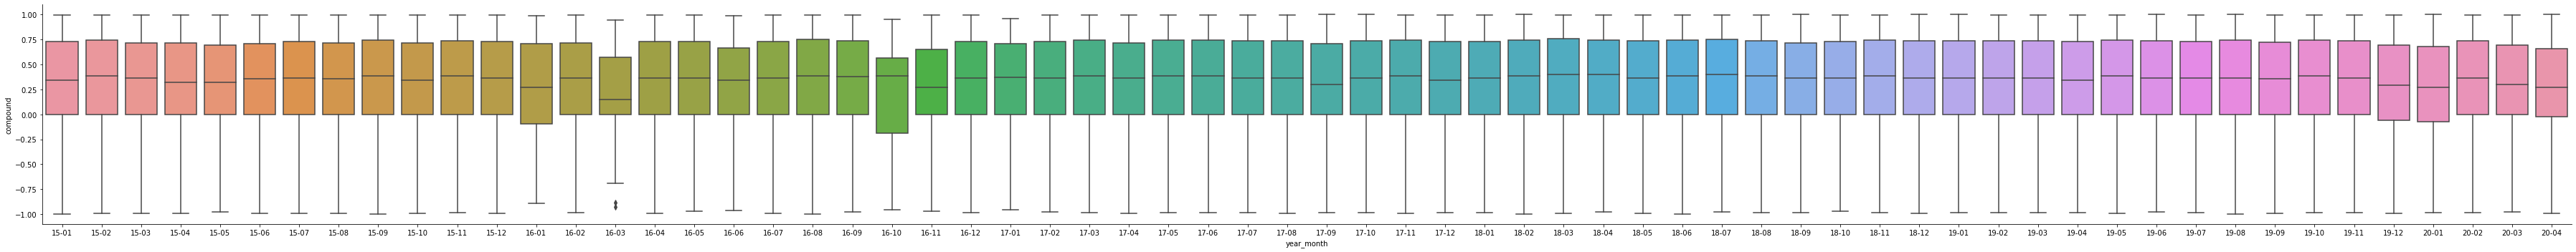

In [9]:
sns.catplot(x="year_month", y="compound", kind="box", data=df,height=5,aspect=10)

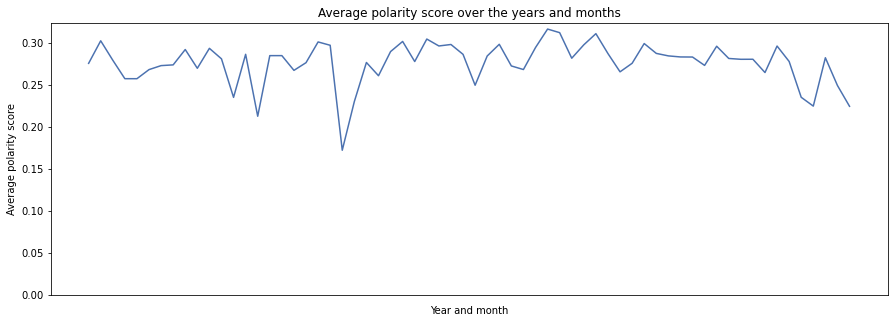

In [10]:
avg_scores = df.compound.groupby(by=df.year_month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=df.year_month.cat.categories, y=avg_scores)

g.set_xlabel("Year and month")
g.set_ylabel("Average polarity score")
g.set(xticklabels=[])
g.set_title("Average polarity score over the years and months")
g.set_ylim(0)
g.tick_params(bottom=False)

We notice a dip in November 2016

## Yearly-monthly-daily category

C:\Users\Harold\AppData\Local\Temp/ipykernel_10956/3798919641.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=ticks_labels)


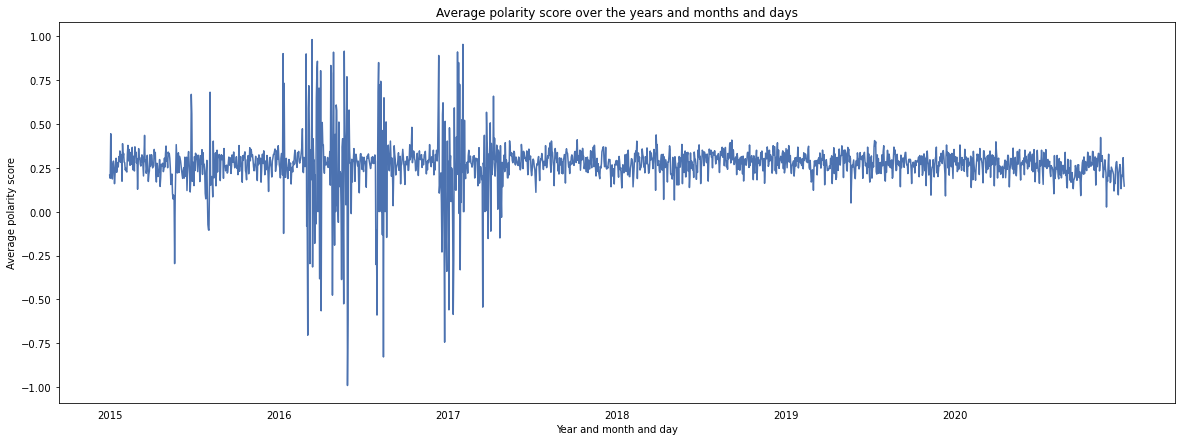

In [11]:
avg_scores = df.compound.groupby(by=df.year_month_day).mean()

f,x = plt.subplots(1,1,figsize=(20,7))

g =sns.lineplot(x=avg_scores.index, y=avg_scores)
length = len(avg_scores)
years= [2015,2016,2017,2018,2019,2020]
step = length// len(years)
ticks_labels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]

g.set_xlabel("Year and month and day")
g.set_ylabel("Average polarity score")
g.set(xticklabels=ticks_labels)
g.set_title("Average polarity score over the years and months and days")
g.tick_params(bottom=False) 


Looking at this, it seems like that the narrative hasn't been increasingly polarized but it has know periods with very high polarity, let us investiage those time periods.

C:\Users\Harold\AppData\Local\Temp/ipykernel_10956/3642520798.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=ticks_labels)


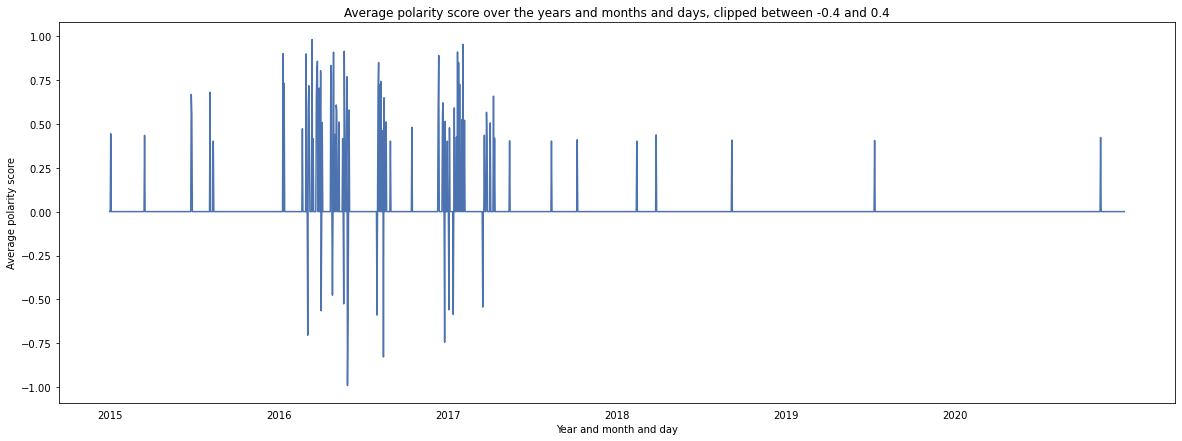

In [12]:
test = avg_scores[:].copy()
test[(test < 0.4) & (test > -0.4)] = 0

f,x = plt.subplots(1,1,figsize=(20,7))

g =sns.lineplot(x=avg_scores.index, y= test)
length = len(avg_scores)
years= [2015,2016,2017,2018,2019,2020]
step = length// len(years)
ticks_labels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]

g.set_xlabel("Year and month and day")
g.set_ylabel("Average polarity score")
g.set(xticklabels=ticks_labels)
g.set_title("Average polarity score over the years and months and days, clipped between -0.4 and 0.4")
g.tick_params(bottom=False) 

In [13]:
## finding the periods with the highest polarity scores

sorted_scores = avg_scores.sort_values()

In [14]:
# let's find the top 5 periods of high polartiy in both directions

k = 5

for i in range(k):
    print(f"Date:{sorted_scores.index[i]} Polarity score: {sorted_scores[i]}\n")

for i in range(k):
    print(f"Date:{sorted_scores.index[-(i+1)]} Polarity score: {sorted_scores[-(i+1)]}\n")

Date:16-04-09 Polarity score: -0.9895

Date:16-06-20 Polarity score: -0.8271

Date:16-10-16 Polarity score: -0.743

Date:16-01-06 Polarity score: -0.7033

Date:16-04-10 Polarity score: -0.6124

Date:16-01-19 Polarity score: 0.9789

Date:16-11-24 Polarity score: 0.95165

Date:16-04-02 Polarity score: 0.913

Date:16-11-13 Polarity score: 0.90855

Date:16-03-06 Polarity score: 0.9072



It looks like 2016 is the period with the highest polarization around climate change. This could be linked with the 2016 USA Election which was highly polarized.

Let's investigate.

## Analysis on particular subjects

In [15]:
dummies_avg_year_month_day = df[dummies_col + ['compound']].groupby(by=df.year_month_day).mean()

In [16]:
sorted_dummies = dummies_avg_year_month_day.sort_values(by='compound')

Let's print the specific subjects that occur during highly polarized days

In [17]:
sorted_dummies.iloc[0,-1]

-0.9895

In [72]:
# let's find the top 5 periods of high polartiy in both directions

k = 15
offset = 15
negatve_index = []
positive_index= []

print("Negative headlines\n")

for i in range(k):
    index = sorted_dummies[dummies_col].iloc[i+offset].argmax()
    subject = dummies_col[index]
    negatve_index.append(sorted_dummies.index[i+offset])
    print(f"Date:{ sorted_dummies.index[i]}\tPolarity score: {sorted_dummies.iloc[i,-1]:.3f}\tSubject: {subject}\n")


print("Positive headlines\n")
for i in range(k):
    index = sorted_dummies[dummies_col].iloc[-(i+1+offset)].argmax()    
    subject = dummies_col[index]
    positive_index.append(sorted_dummies.index[-(i+1+offset)])
    print(f"Date: {sorted_dummies.index[-(i+1)]}\tPolarity score: {sorted_dummies.iloc[-(i+1),-1]:.3f}\tSubject: {subject}\n")

Negative headlines

Date:16-04-09	Polarity score: -0.990	Subject: agriculture

Date:16-06-20	Polarity score: -0.827	Subject: carbon

Date:16-10-16	Polarity score: -0.743	Subject: nuclear

Date:16-01-06	Polarity score: -0.703	Subject: gas

Date:16-04-10	Polarity score: -0.612	Subject: emission

Date:16-06-05	Polarity score: -0.589	Subject: sustainable

Date:16-11-04	Polarity score: -0.585	Subject: climate

Date:16-02-08	Polarity score: -0.564	Subject: earth

Date:16-10-25	Polarity score: -0.559	Subject: climate

Date:17-01-03	Polarity score: -0.543	Subject: gas

Date:16-04-01	Polarity score: -0.525	Subject: climate

Date:16-03-02	Polarity score: -0.475	Subject: warming

Date:16-03-28	Polarity score: -0.387	Subject: emission

Date:16-02-05	Polarity score: -0.382	Subject: agriculture

Date:16-02-06	Polarity score: -0.382	Subject: agriculture

Positive headlines

Date: 16-01-19	Polarity score: 0.979	Subject: carbon

Date: 16-11-24	Polarity score: 0.952	Subject: earth

Date: 16-04-02	Polari

In [73]:
negatve_index

['16-10-20',
 '16-11-18',
 '16-01-20',
 '16-06-01',
 '16-01-14',
 '15-05-02',
 '16-11-05',
 '16-10-11',
 '16-03-10',
 '16-01-25',
 '16-10-19',
 '16-10-15',
 '17-01-13',
 '17-02-08',
 '16-06-26']

In [74]:

for date in negatve_index:
    print(df[df.year_month_day == date].quotation.to_markdown())



|        | quotation                                                                                                    |
|-------:|:-------------------------------------------------------------------------------------------------------------|
| 221801 | most of the water in israel goes to agriculture which is crazy because most of the agriculture is for export |
|        | quotation                                                                                                                                                                                                                    |
|-------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 209641 | just because that s the way we ve always done it or always have been doing it for x number of years doesn t mean there s not a better and more sustainable 

In [75]:

for date in positive_index:
    print(df[df.year_month_day == date].quotation.to_markdown())

|        | quotation                                                                                                                                                                                                                                                                                      |
|-------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 217232 | achieving the security and peace of a world without nuclear weapons will not happen quickly perhaps not in my lifetime                                                                                                                                                                         |
| 221630 | researches have shown that the 62 trillion spam emails sent each year waste 33 billion ki

- remove atmosphere
- remove  nuclear
- ecosystem"

